In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/jkrieger/work/ray_tracing/python')
import mantaray

In [2]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

## Initialize wave parameters

In [3]:
# Period of incident waves in seconds
T0 = 11
# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = theta_deg * (np.pi/180)
# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)
# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100
# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
current = 'data/currents/output_ncom_refraction_current_small_scale.nc'
bathymetry = 'data/bathymetry/bathy_zonal_jet.nc'

ds = xr.open_dataset(current)

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
x0 = 10*np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])
# Computes group velocity
cg = group_velocity(k0)
# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

## Load in Saildrone data

In [4]:
pilot_1062 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1062.nc')
start_date = '2021-10-30T11:00:00.000000000' # start date and time of front
end_date = '2021-10-30T22:00:00.000000000' # end date and time of front
sub_sd = pilot_1062.sel(time=slice(start_date, end_date))
non_masked = sub_sd['sea_surface_wave_significant_height'].where(~sub_sd['sea_surface_wave_significant_height'].isnull(), drop=True) 

# Extract longitude and latitude of SMODE data
sd_lon = non_masked.longitude.values
sd_lat = non_masked.latitude.values

# Extract NCOM coordinate extents
ncom_x_min, ncom_x_max = ds.x.min().item(), ds.x.max().item()
ncom_y_min, ncom_y_max = ds.y.min().item(), ds.y.max().item()

# Convert SMODE lat/lon to meters using a reference latitude
ref_lat = np.mean(sd_lat)

# Convert longitude and latitude to meters using a standard approximation
sd_x_meters = ((sd_lon - sd_lon.min()) * 1_852 * 60 * np.cos(np.deg2rad(ref_lat))) / 1_000
sd_y_meters = ((sd_lat - sd_lat.min()) * 1_852 * 60) / 1_000

# Scale and shift SMODE coordinates to fit within a small section in the middle of the plot
sd_x_meters = (sd_x_meters - sd_x_meters.mean()) + (ncom_x_max + ncom_x_min) / 2
sd_y_meters = (sd_y_meters - sd_y_meters.mean()) + (ncom_y_max + ncom_y_min) / 2

## Initialize ray tracing & ray positions

In [5]:
x0 = np.linspace(0, 200, num=100)  # 100 rays spread from 0 to 200 in x
y0 = np.full_like(x0, 220)  # Set y positions at 220
bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current)

In [15]:
bundle.x[1]

<xarray.DataArray 'x' (time_step: 236)> Size: 2kB
array([  2.02020202,   2.61403803,   3.20256993,   3.7885877 ,
         4.37341964,   4.95636486,   5.53631071,   6.1131119 ,
         6.68935221,   7.27120774,   7.86142538,   8.45662883,
         9.05229483,   9.64851091,  10.24634362,  10.84519917,
        11.44339729,  12.04006369,  12.63523967,  13.23006389,
        13.8255347 ,  14.42202935,  15.01867731,  15.61493633,
        16.21076881,  16.80653121,  17.40246307,  17.99858272,
        18.59471662,  19.19081452,  19.78703141,  20.38372714,
        20.98058003,  21.57613005,  22.16901763,  22.7583165 ,
        23.34417422,  23.92715664,  24.50767761,  25.086031  ,
        25.66249803,  26.23734592,  26.81074933,  27.38285664,
        27.95390851,  28.52407667,  29.09339974,  29.66187545,
        30.22931675,  30.7956283 ,  31.36081304,  31.92494696,
        32.48814076,  33.05062518,  33.61249658,  34.1737822 ,
        34.73429694,  35.29362317,  35.85110767,  36.40626592,
        36.95912137,  37.51031164,  38.06090458,  38.61221581,
        39.16558558,  39.72224338,  40.28257158,  40.84618377,
        41.41242306,  41.98062885,  42.55025503,  43.12080774,
        43.69141238,  44.26107041,  44.82900606,  45.39484813,
        45.95840305,  46.51983676,  47.07952022,  47.63806879,
...
        90.58180656,  91.10090446,  91.6188248 ,  92.13721776,
        92.65747685,  93.17967208,  93.70317083,  94.22738771,
        94.75159421,  95.27505588,  95.79735005,  96.31865118,
        96.84009534,  97.36330947,  97.88940888,  98.4177033 ,
        98.94688961,  99.4761686 , 100.00542425, 100.53491112,
       101.06450596, 101.59387402, 102.12294211, 102.65230025,
       103.18281656, 103.71477339, 104.24913068, 104.78955917,
       105.34282759, 105.91536782, 106.50502745, 107.1058233 ,
       107.71215403, 108.31982087, 108.92727609, 109.53422157,
       110.13984042, 110.74289887, 111.34123611, 111.93333017,
       112.51914714, 113.09942942, 113.67490356, 114.24631506,
       114.81411652, 115.37868453, 115.94056268, 116.500019  ,
       117.05744807, 117.61306272, 118.16705757, 118.71974783,
       119.27188326, 119.82419371, 120.37748587, 120.93195639,
       121.48770337, 122.04443294, 122.60141044, 123.1579229 ,
       123.71315782, 124.26622897, 124.8163624 , 125.36261569,
       125.90637031, 126.45148761, 127.00174653, 127.55768041,
       128.11913793, 128.68574257, 129.25699233, 129.83376528,
       130.4172767 , 131.00591089, 131.5970507 , 132.18900332,
       132.7813037 , 133.37336566, 133.96309801, 134.54843513])
Coordinates:
  * time_step  (time_step) int64 2kB 0 1 2 3 4 5 6 ... 230 231 232 233 234 235
    ray        int64 8B 1
    time       (time_step) float64 2kB 0.0 0.1109 0.2218 ... 25.84 25.95 26.06
    x          (time_step) float64 2kB 2.02 2.614 3.203 ... 133.4 134.0 134.5
    y          (time_step) float64 2kB 220.0 219.2 218.5 ... 31.74 30.94 30.13

## Plot the jawn

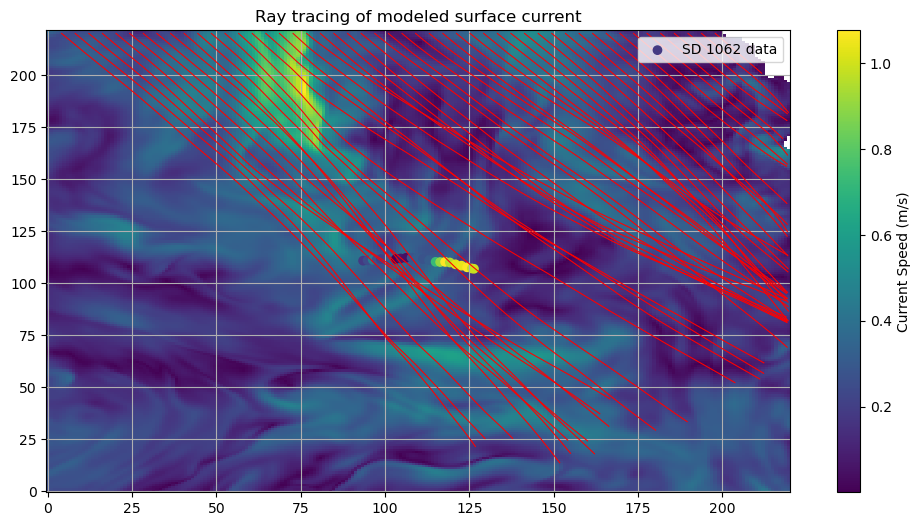

In [14]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, U)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
plt.scatter(sd_x_meters, sd_y_meters, c=non_masked, marker='o', label='SD 1062 data')
plt.legend(loc='upper right')
plt.title('Ray tracing of modeled surface current')
plt.colorbar(cs, label='Current Speed (m/s)')
plt.grid(axis='both')
#plt.savefig('small_scale_refraction_ray_tracing.png', dpi=300, bbox_inches='tight')